In [1]:
import multiprocessing as mp                                                                         
import os                                                                                            
import numpy as np                                                                                   
import awkward as ak                                                                                 
import matplotlib.pyplot as plt                                                                      
import matplotlib                                                                                    
import uproot                                                                                        
import uproot3                                                                                       
from tools.roottree import read_tree                                                                 
from tools.selections import *                                                                       
import scipy.stats                                                                                   
from scipy.optimize import curve_fit                                                                 
from tools.studybeta import hist1d, hist2d, hist_beta, getbeta, hist_betabias, compute_moment 

/home/manbing/.local/lib/python3.10/site-packages/awkward0/__init__.py:5: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils.version


In [3]:
from tools.plottools import plot1dhist, plot2dhist, plot1d_errorbar, FIGSIZE_MID, FIGSIZE_BIG, setplot_defaultstyle, format_order_of_magnitude, FONTSIZE, savefig_tofile, FONTSIZE_BIG, plot1d_errorbar_v2, tick_length, tick_labelsize, tick_width                                                          
from tools.studybeta import calc_signal_fraction, hist1d, hist1d_weighted                                                                      
from tools.binnings_collection import get_nbins_in_range, get_sub_binning, get_bin_center            
from tools.studybeta import minuitfit_LL, cdf_gaussian, calc_signal_fraction, cdf_double_gaus, double_gaus                                                                                               
from tools.histograms import Histogram, WeightedHistogram, plot_histogram_1d                         
from tools.binnings import Binning                                                                   
from tools.constants import NUCLEI_CHARGE                                                            
from tools.calculator import calc_ekin_from_beta                                                     
from tools.calculator import calculate_efficiency_and_error, calculate_efficiency_and_error_weighted, calculate_efficiency_weighted                                                                      
from tools.statistics import poly_func                                                               
from tools.graphs import MGraph, slice_graph, concatenate_graphs                                     
from tools.utilities import get_spline_from_graph, save_spline_to_file, get_graph_from_spline, get_spline_from_file                                                                                      
import pickle                                                                                        
from scipy.interpolate import make_interp_spline, BSpline                                            
                                                                

In [4]:
with open('/home/manbing/Documents/Data/jiahui/efficiency/eff_cor_be_10yr_updated.pkl', 'rb') as f:
    data_jiahui_eff = pickle.load(f)
    eff_cor_bz_jw = data_jiahui_eff[2][0]

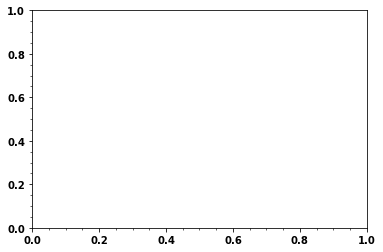

In [5]:
#xbinning = fbinning_energy_agl()
setplot_defaultstyle()
kNucleiBinsRebin = np.array([0.8,1.00,1.16,1.33,1.51,1.71,1.92,2.15,2.40,2.67,2.97,3.29,3.64,4.02,4.43,4.88,    
                             5.37,5.90,6.47,7.09,7.76,8.48,9.26, 10.1,11.0,12.0,13.0,14.1,15.3,16.6,18.0,19.5,21.1,22.8,24.7,26.7,28.8,31.1,33.5,36.1,    
                             38.9,41.9,45.1,48.5,52.2,60.3,69.7,80.5,93.0,108., 116.,147.,192.,259.,379.,660., 1300, 3300.])
kNucleiBinsRebin_center = get_bin_center(kNucleiBinsRebin)
RIG_XLIM =[1.8, 1000]
RIG_XLABEL = "Rigidity (GV)"

def get_ratio_and_err(a, b, delta_a, delta_b):
    ratio = a/b
    err = a/b * np.sqrt((delta_a / a)**2 + (delta_b / b)**2)
    return ratio, err

def get_ratio_err(a, b, delta_a, delta_b):        
  return a/b * np.sqrt((delta_a / a)**2 + (delta_b / b)**2)   

def inntrk_func(x, polypars, constant, transitionpoint):
    left = x < transitionpoint
    right = x >= transitionpoint
    y = np.zeros_like(x)
    y[left] = poly_func(x[left], *polypars)
    y[right] = constant
    return y    
    
def get_trigger_eff(hist_phystrigger, hist_unbiastrigger, datatype):
    factor = 100 if datatype == "ISS" else 1.0
    trigger_eff = hist_phystrigger.values[1:-1]/(hist_phystrigger.values[1:-1] + factor * hist_unbiastrigger.values[1:-1])
    err_a = hist_phystrigger.get_errors()[1:-1]
    err_b = hist_unbiastrigger.get_errors()[1:-1]
    b = hist_phystrigger.values[1:-1]
    a = hist_unbiastrigger.values[1:-1]
    #trigger_err = 1/(a + b)**2 * np.sqrt((factor*b)**2 * aerr**2 + (factor*a)**2 * berr**2)
    if datatype == "ISS":
        trigger_err = 1/(a+ b * 100)**2 * np.sqrt((factor*b)**2 * err_a**2 + (factor*a)**2 * err_b**2)
    else:
        trigger_err = 1/(a+b)**2 * np.sqrt((err_a * b)**2 + (err_b * a )**2)
    return trigger_eff, trigger_err

def read_roothist(rootfile, histname=None, labelx=None):
    hist = rootfile[histname]
    bincontent, bindeges = hist.to_numpy(flow=True)
    binerrors = hist.errors(flow=True)
    xbinning = Binning(bindeges)
    hist1dpy = WeightedHistogram(xbinning, values=np.array(bincontent), squared_values=binerrors**2, labels=[labelx])
    return hist1dpy

def calculate_efficiency_from_hist(histpass, histtot, datatype, flow=False, asGraph=True):
    npass, binedges = histpass.to_numpy(flow=flow)
    ntot, binedges = histtot.to_numpy(flow=flow)
    eff, efferr = calculate_efficiency_and_error(npass, ntot, datatype)

    if asGraph:
        xvalue = get_bin_center(binedges)
        return MGraph(xvalue, eff, efferr)
    else:
        return eff, efferr 

def fill_hist_ekin_counts(events, ekinbinning, isdata=True):
    richbeta = get_richbeta(events, is_data=isdata)
    ekin_rich = calc_ekin_from_beta(richbeta)
    hist = Histogram(ekinbinning, labels=["Ekin/n (GeV/n)", "events"]) 
    hist.fill(ekin_rich)
    return hist

def plot_comparison_twohist(figure=None, ax1=None, ax2=None, histA=None, histB=None, ratio=None, ratioerr=None, xlog=True, ylog=False, isotope=None, xlabel=None, ylabel=None, figname=None, save=False, cutname=None):
    #if figure==None:        
    #   figure, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.6, 0.4]}, figsize=(16, 14))
    if cutname == "trigger":
        labelA = f"{isotope} Unbias"
        labelB = f"{isotope} Physics"
    else:
        labelA= f'{isotope} total'
        labelB = f'{isotope} pass'
    plot_histogram_1d(ax1, histA, style="iss", color="tab:blue", label=labelA, xlog=xlog, ylog=ylog,  setscilabely=True, markersize=20, show_overflow=False)
    plot_histogram_1d(ax1, histB, style="iss", color="tab:orange", label=labelB, scale=None, gamma=None, xlog=True, ylog=False, shade_errors=False, show_overflow=False, adjust_limits=None, adjust_limits_x=None, adjust_limits_y=None, flip_axes=False, override_limits=False, use_approximate_poisson_errors=False, draw_zeros=True, setscilabelx=False, setscilabely=True, markersize=20)
    xbinning = histA.binnings[0] 
    plot1dhist(figure, ax2, xbinning=xbinning.edges[1:-1], counts=ratio, err=ratioerr,  label_x=xlabel, label_y="ISS/MC", legend=None,  col="black", setlogx=True, setlogy=False, setscilabelx=False,  setscilabely=False)
    plt.subplots_adjust(hspace=.0)                                                               
    ax1.legend()
    ax2.sharex(ax1)
    if (save):
        savefig_tofile(figure, "trees/acceptance", f"hist_{figname}_rig_passtotalevent", show=False)
     
isotopes = {"Li": ["Li6", "Li7"], "Be": ["Be7", "Be9", "Be10"], "Boron": ["Bo10", "Bo11"], "Carbon": ["C12"]}
color_iso = {"ISS": "black", "Be7": "tab:orange", "Be9": "tab:blue", "Be10": 'tab:green', "C12": 'tab:orange'}
color_cut = {"l1q": "magenta", "tof": "tab:blue", "inntof": "tab:orange", "inncutoff": "tab:orange", "pk": "brown", "bz": "tab:red", "trigger": "green", "total": "black"}
xlabel = {"Rigidity" : "Rigidity (GV)", "KineticEnergyPerNucleon": "Ekin/n (GeV/n)"}   
chargename = {"Li": "z3", "Be": "z4", "Boron": "z5", "Carbon": "z6"}

studyeff = ["l1q", "tof", "inntof", "inncutoff",  "bz", "trigger"]
#studyeff = ["inntof", "inncutoff"]
cutname = {"l1q": "L1 unbiased charge", "tof": "Tof charge", "inntof": "Inner Track(Rtof)", "inncutoff": "Inner Track(Rcutoff)", "pk": "L1 picking up", "bz" : "L1 big charge", "trigger": "trigger"}
cutplotlim = {"l1q": [0.95, 1.02], "tof": [0.975, 1.005], "inntof": [0.78, 0.95], "inncutoff": [0.78, 0.95], "pk": [0.7, 1.0], "bz" : [0.7, 0.85], "trigger": [0.985, 1.005]}
effcorplotlim = {"l1q": [0.95, 1.05], "tof": [0.98, 1.02], "inntof": [0.9, 1.08], "inncutoff": [0.9, 1.08], "pk": [0.9, 1.1], "bz" : [0.95, 1.075], "trigger": [0.985, 1.015]}

def get_efficiency(nuclei, filename, datatype, variable):
    znum = chargename[nuclei]
    histnameden = {"l1q":       f"h_l1q_den_{znum}_0",
                   "tof":       f"h_tof_den_{znum}_0",
                   "inntof":    f"h_inn_den_{znum}_0_0",
                   "inncutoff": f"h_inn_den_{znum}_0_1",
                   "pk":        f"h_pk_den_{znum}_0",
                   "bz":        f"h_bz_den_{znum}_0",
                   "trigger":   f"h_trigger_{znum}_0_ub2"}
    
    histnamenum = {"l1q" :      f"h_l1q_num_{znum}_0",
                   "tof":       f"h_tof_num_{znum}_0",
                   "inntof":    f"h_inn_num_{znum}_0_0",
                   "inncutoff": f"h_inn_num_{znum}_0_1",
                   "pk":        f"h_pk_num_{znum}_0",
                   "bz":        f"h_bz_num_{znum}_0",
                   "trigger":   f"h_trigger_{znum}_0_phy2"}

    hist_den = dict()
    hist_num = dict()
    eff = dict()
    efferr = dict()
    dict_hist_eff = dict()

    with uproot.open(filename) as rootfile:
        for i, cut in enumerate(studyeff):
            hist_den[cut] = read_roothist(rootfile, histnameden[cut], labelx=xlabel[variable])
            hist_num[cut] = read_roothist(rootfile, histnamenum[cut], labelx=xlabel[variable])
            xbinning = hist_den[cut].binnings[0]
            hist_tot = rootfile[histnameden[cut]]
            hist_pass = rootfile[histnamenum[cut]]
            xvalues = xbinning.bin_centers[1:-1]
            if cut == "trigger":
                eff[cut], efferr[cut] = get_trigger_eff(hist_num[cut], hist_den[cut], datatype)
                grapheff = MGraph(xvalues, eff[cut], efferr[cut]) 
            else:
                grapheff = calculate_efficiency_from_hist(hist_pass , hist_tot, datatype)
                #eff[cut], efferr[cut] = calculate_efficiency_and_error(hist_num[cut].values, hist_den[cut].values, datatype)
            
            dict_hist_eff[cut]  = grapheff
            
            figure, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.55, 0.45]}, figsize=(16, 12))
            plot_comparison_twohist(figure, ax1, ax2, histA=hist_den[cut], histB=hist_num[cut], ratio=grapheff.gety(), ratioerr=grapheff.get_yerrors(), xlog=True, ylog=False, isotope=datatype, xlabel=xlabel[variable], ylabel="Efficiency", figname=f"{nuclei}{datatype}_{cut}", cutname=cut)
            ax1.text(0.03, 1.0, f"{cutname[cut]}", fontsize=FONTSIZE_BIG, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold") 
            plt.subplots_adjust(hspace=.0)
            #if (cut != "inn"):
            #    ax1.set_ylim([0, 1.14 * max(hist_den[cut].values)])
            ax1.set_xlim([2, 1300])
            ax1.set_xticks([2, 5,  10, 30,  80,  300, 1000])
            ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
            ax1.get_yticklabels()[0].set_visible(False)
            ax2.set_ylim(cutplotlim[cut])                                                                     
            savefig_tofile(figure, "trees/acceptance", f"hist_{nuclei}{datatype}_{cut}_passevent", show=False)
            
    return dict_hist_eff

def plot_graph_eff(figure, plot, graph_eff, isotope=None, legend=None, col=None):
    plot1d_errorbar_v2(figure, plot,  graph_eff.getx(), graph_eff.gety(), err=graph_eff.get_yerrors(), label_x="Rigidity", label_y="Efficiency", label=legend, color=color_iso[isotope] if col is None else col, style=".", legendfontsize=FONTSIZE_BIG, setlogx=True, setlogy=False, setscilabelx=False, setscilabely=False)
    
    
def plot_curvefit(figure, plot, graph, func, pars, col=None, label=None):
    plot.plot(graph.getx()[:], func(np.log(graph.getx()[:]), *pars), '-', label=label, color=col)

def get_nppolyfit(x, y, deg):
    coeffs1 = np.polyfit(x, y, deg=deg)
    fit1 = np.poly1d(coeffs1)
    return fit1

def getpars_curvefit_poly(datagraph, deg):
    initial_guess = np.zeros(deg) # Initial guess for the polynomial coefficients
    fit_coeffs, _ = curve_fit(poly_func, np.log(datagraph.getx()[:]), datagraph.gety()[:], sigma=datagraph.get_yerrors()[:], p0=initial_guess)
    return fit_coeffs


def set_axes_style(ax1, ax2, ax1_ylim=None, ax2_ylim=None, ax1_xlim=None, ax2_xlim=None, ax1_ylabel=None, ax2_ylabel=None, ax2_xlabel=None):
    if ax1_ylim is not None:
        ax1.set_ylim(ax1_ylim)
    if ax1_xlim is not None:
        ax1.set_xlim(ax1_xlim)
    if ax2_ylim is not None:
        ax2.set_ylim(ax2_ylim)
    if ax2_xlim is not None:
        ax2.set_xlim(ax2_xlim)
    ax2.set_xticks([2, 5, 10, 30,  100,  300, 1000])
    ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax2.set_ylabel(ax2_ylabel)
    ax1.set_ylabel(ax1_ylabel)
    ax2.set_xlabel(ax2_xlabel)
    ax1.sharex(ax2)
    plt.subplots_adjust(hspace=.0)
    plt.grid()
    ax1.grid()
    ax1.get_yticklabels()[0].set_visible(False)
    

   

In [30]:
filename_iss = "/home/manbing/Documents/Data/data_BeP8/acceptance/efficiency"
filenames_mc = {'Be7': "/home/manbing/Documents/Data/data_BeP8/acceptance/efficiency/Be7MC_B1236_anaflux_choutko.root", 
                'Be9': "/home/manbing/Documents/Data/data_BeP8/acceptance/efficiency/Be9MC_B1236_anaflux_choutko.root",
                'Be10': "/home/manbing/Documents/Data/data_BeP8/acceptance/efficiency/Be10MC_B1236_anaflux_choutko.root"}
                
nuclei = 'Be'
variable = 'Rigidity'
plotfile = '/home/manbing/Documents/lithiumanalysis/scripts/efficiency/plots'

dictgraph_eff_iss = {}
dictgraph_eff_iss =  get_efficiency(nuclei, args.filename_iss, f"ISS {nuclei}", variable)
for i, isotope in enumerate(isotopes[nuclei]):  
    dictgraph_eff_mc[nuclei] = get_efficiency(nuclei, filename_mc[isotope], f"MC {isotope}", variable)   
    
    dictgraph_eff_iss = {nuclei: dict() for nuclei in nucleus}
    dictgraph_eff_mc = {nuclei: {iso: dict() for iso in isotopes[nuclei]} for nuclei in nucleus}
    dict_eff_cor = {nuclei: {iso: dict() for iso in isotopes[nuclei]} for nuclei in nucleus}
    dict_polyfitpars_effcor = {nuclei: {iso: dict() for iso in isotopes[nuclei]} for nuclei in nucleus}
    filename_mc = {nuclei: {isotope: f'trees/eff_corr/{isotope}MC_anaflux.root' for isotope in isotopes[nuclei]} for nuclei in nucleus}
    graph_inntrack_eff_iss = dict()
    graph_inntrack_eff_mc = {nuclei: dict() for nuclei in nucleus}
    graph_inntrack_eff_mc_short = {nuclei: dict() for nuclei in nucleus}
    graph_inntrack_effcor = {nuclei: dict() for nuclei in nucleus}
    graph_inntrack_effcor_test = {nuclei: dict() for nuclei in nucleus}
    fitinntrk  = {nuclei: dict() for nuclei in nucleus}
    spline_inntrk  = {nuclei: dict() for nuclei in nucleus}   
    for nuclei in nucleus:
        dictgraph_eff_iss[nuclei] =  get_efficiency(nuclei, args.filename_iss, "ISS", variable)
        for i, isotope in enumerate(isotopes[nuclei]):        
            dictgraph_eff_mc[nuclei][isotope] = get_efficiency(nuclei, filename_mc[nuclei][isotope], f"{isotope}MC", variable)
            for cut in studyeff:
                dict_eff_cor[nuclei][isotope][cut] = dictgraph_eff_iss[nuclei][cut]/dictgraph_eff_mc[nuclei][isotope][cut]
                initial_guess = np.zeros(2) # Initial guess for the polynomial coefficients
                fitrange = [1, -1]
                xlim = fitrange[0]
                ylim = fitrange[1]
                if "inn" not in cut:
                    dict_polyfitpars_effcor[nuclei][isotope][cut]  = getpars_curvefit_poly(dict_eff_cor[nuclei][isotope][cut], 3)
               
        for cut in studyeff:  
            figure, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.6, 0.4]}, figsize=(16, 13))
            plot_graph_eff(figure, ax1, dictgraph_eff_iss[nuclei][cut], "ISS", legend="ISS")
            for i, isotope in enumerate(isotopes[nuclei]):
                plot_graph_eff(figure, ax1, dictgraph_eff_mc[nuclei][isotope][cut], isotope, legend=f"{isotope}")
                plot_graph_eff(figure, ax2, dict_eff_cor[nuclei][isotope][cut], isotope)
                if "inn" not in cut:
                    plot_curvefit(figure, ax2, dict_eff_cor[nuclei][isotope][cut], poly_func, dict_polyfitpars_effcor[nuclei][isotope][cut])


            ax1.set_ylim(cutplotlim[cut])
            ax2.set_ylim(effcorplotlim[cut])
            ax1.text(0.1, 0.95, f"{cutname[cut]}", fontsize=FONTSIZE_BIG, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold") 
            ax1.legend(loc='lower right')
            ax2.set_xlim([1.8, 1300])
            ax2.set_xticks([2, 5, 10, 30,  100,  300, 1000])
            ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
            ax2.set_ylabel("ISS/MC")
            ax1.sharex(ax2)
            plt.subplots_adjust(hspace=.0)
            plt.grid()
            ax1.grid()
            ax1.get_yticklabels()[0].set_visible(False)
            savefig_tofile(figure, args.resultdir, f"hist_{nuclei}_{cut}_rig_efficiency", show=False)
            
    #BZ efficiency
    figure, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.6, 0.4]}, figsize=(16, 13))
    graph_bz = dict_eff_cor["Be"]["Be7"]["bz"]
    plot_graph_eff(figure, ax1, graph_bz, "Be7")
    fit_bz_eff = poly_func(np.log(graph_bz.getx()[:]), *dict_polyfitpars_effcor["Be"]["Be7"]["bz"])
    fit_bz_eff[graph_bz.get_index(108):] = fit_bz_eff[graph_bz.get_index(108)] * np.ones_like(fit_bz_eff[graph_bz.get_index(108):]) 
    ax1.plot(graph_bz.xvalues, eff_cor_bz_jw(np.log(dict_eff_cor["Be"]["Be7"]["bz"].xvalues)), "-", color="black", label="J.W")
    ax1.plot(graph_bz.xvalues, fit_bz_eff, "-", color="blue", label="fit")
    ax2.plot(graph_bz.xvalues, fit_bz_eff/eff_cor_bz_jw(np.log(graph_bz.xvalues)), "-", color="black")
    ax1.set_ylim([0.95, 1.05])
    ax2.set_ylim([0.98, 1.01])
    ax1.set_xscale("log")
    ax2.set_xscale("log")
    ax2.set_xlim([2, 1300])
    ax2.set_xticks([2, 5,  10, 30,  80,  300, 1000])
    ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax1.get_yticklabels()[0].set_visible(False)
    #ax1.sharex(ax2)
    ax2.set_xlabel(RIG_XLABEL)
    ax2.set_ylabel("this/J.W")
    plt.subplots_adjust(hspace=.0)
    #set_axes_style(ax1, ax2, ax1_ylim=cutplotlim["bz"], ax2_ylim=[0.98, 1.02], ax2_xlim=RIG_XLIM, ax1_ylabel="Eff Correction", ax2_ylabel="this/J.W", ax2_xlabel=RIG_XLABEL)

    savefig_tofile(figure, args.resultdir, f"hist_compare_jw_bz_effcor", show=True)
    plt.show()


        

usage: ipykernel_launcher.py [-h] [--title TITLE]
                             [--filename_iss FILENAME_ISS]
                             [--filenames_mc FILENAMES_MC]
                             [--treename TREENAME] [--chunk-size CHUNK_SIZE]
                             [--nprocesses NPROCESSES] [--resultdir RESULTDIR]
                             [--dataname DATANAME] [--nuclei NUCLEI]
                             [--variable VARIABLE]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/manbing/.local/share/jupyter/runtime/kernel-94903507-6b3f-4af5-a23a-0abcf55c87c9.json


SystemExit: 2